First, we take the dataset and merge the title and text columns into a single one, then print the first few lines to validate what we're doing.

In [7]:
import pandas as pd

df = pd.read_csv('../datasets/WELFake_Dataset.csv')

df.fillna({'title': '', 'text': ''}, inplace=True)

df.drop(columns=['Unnamed: 0'], inplace=True)

df['text'] = df['title'] + " " + df['text']

df.drop(columns=['title'], inplace=True)

print(df.head())

                                                text  label
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...      1
1     Did they post their votes for Hillary already?      1
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...      1
3  Bobby Jindal, raised Hindu, uses story of Chri...      0
4  SATAN 2: Russia unvelis an image of its terrif...      1


Then we proceed with preproccesing the text with beautiful soup and nltk.

In [8]:
import re
import string
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from textblob import TextBlob
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\[[^]]*\]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

def extract_features(text):
    features = {}
    features['exclamation_count'] = text.count('!')
    features['question_count'] = text.count('?')
    features['capital_word_count'] = sum(1 for word in text.split() if word.isupper())
    features['sentiment'] = TextBlob(text).sentiment.polarity

    verb_counts = {"present": 0, "past": 0, "future": 0}
    doc = nlp(text)
    for token in doc:
        if token.pos_ == 'VERB':
            if token.tag_ in ['VBP', 'VBZ', 'VBG']:
                verb_counts["present"] += 1
            elif token.tag_ in ['VBD']:
                verb_counts["past"] += 1
            elif token.tag_ in ['MD']:
                verb_counts["future"] += 1
    features.update(verb_counts)
    return features

tqdm.pandas(desc="Processing Text")
df['processed_text'] = df['text'].progress_apply(preprocess_text)

tqdm.pandas(desc="Extracting Features")
df_features = df['text'].progress_apply(extract_features).apply(pd.Series)

df = pd.concat([df, df_features], axis=1)

df.to_pickle('processed_data.pkl')

texts = df['processed_text'].tolist()

additional_features = df[['exclamation_count', 'question_count', 'capital_word_count', 'sentiment', 'present', 'past', 'future']]
labels = df['label']

train_texts, test_texts, train_additional_features, test_additional_features, train_labels, test_labels = train_test_split(
    texts, additional_features, labels, test_size=0.2, random_state=42
)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Claudiu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Claudiu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Claudiu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Processing Text:   1%|          | 414/72134 [00:01<04:49, 247.44it/s]C:\Users\Claudiu\AppData\Local\Temp\ipykernel_1224\4053827100.py:25: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
Extracting Features: 100%|██████████| 72134/72134 [1:13:27<00:00, 16.37it/s]


In [2]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class BERTDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

class CustomDataset(Dataset):
    def __init__(self, texts, additional_features, labels):
        self.encodings = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
        self.additional_features = torch.tensor(additional_features.values, dtype=torch.float)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['additional_features'] = self.additional_features[idx]
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# baseline_train_dataset = BERTDataset(train_texts, train_labels)
# baseline_test_dataset = BERTDataset(test_texts, test_labels)
# enhanced_train_dataset = CustomDataset(train_texts, train_additional_features, train_labels)
# enhanced_test_dataset = CustomDataset(test_texts, test_additional_features, test_labels)


In [21]:
torch.save(baseline_train_dataset, 'baseline_train_dataset.pt')
torch.save(baseline_test_dataset, 'baseline_test_dataset.pt')
torch.save(enhanced_train_dataset, 'enhanced_train_dataset.pt')
torch.save(enhanced_test_dataset, 'enhanced_test_dataset.pt')

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

baseline_train_dataset = torch.load('baseline_train_dataset.pt')
baseline_test_dataset = torch.load('baseline_test_dataset.pt')
enhanced_train_dataset = torch.load('enhanced_train_dataset.pt')
enhanced_test_dataset = torch.load('enhanced_test_dataset.pt')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device.type)

baseline_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
baseline_model.to(device)

training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"  
)

trainer = Trainer(
    model=baseline_model,                         
    args=training_args,                  
    train_dataset=baseline_train_dataset,         
    eval_dataset=baseline_test_dataset,
    compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(-1) == p.label_ids).astype(float).mean().item()}
)

trainer.train()
baseline_results = trainer.evaluate()

trainer.save_model("./best_model")

print("Baseline Model Accuracy:", baseline_results['eval_accuracy'])


                                                        
100%|██████████| 10821/10821 [13:22:25<00:00,  3.70s/it]

{'eval_loss': 0.029533175751566887, 'eval_accuracy': 0.9950093574547723, 'eval_runtime': 1620.339, 'eval_samples_per_second': 8.904, 'eval_steps_per_second': 0.139, 'epoch': 3.0}


100%|██████████| 10821/10821 [13:22:27<00:00,  4.45s/it]


{'train_runtime': 48147.0977, 'train_samples_per_second': 3.596, 'train_steps_per_second': 0.225, 'train_loss': 0.03894315632609735, 'epoch': 3.0}


100%|██████████| 226/226 [26:53<00:00,  7.14s/it]


Baseline Model Accuracy: 0.9950093574547723


In [4]:
print(baseline_results)

{'eval_loss': 0.029533175751566887, 'eval_accuracy': 0.9950093574547723, 'eval_runtime': 1620.9927, 'eval_samples_per_second': 8.9, 'eval_steps_per_second': 0.139, 'epoch': 3.0}


100%|██████████| 226/226 [34:57<00:00,  9.28s/it]


Baseline Model Metrics: {'eval_loss': 0.029533175751566887, 'eval_accuracy': 0.9950093574547723, 'eval_precision': 0.9930781758957655, 'eval_recall': 0.9971381847914963, 'eval_f1': 0.9951040391676866, 'eval_runtime': 2106.9601, 'eval_samples_per_second': 6.847, 'eval_steps_per_second': 0.107}


100%|██████████| 226/226 [34:53<00:00,  9.26s/it]


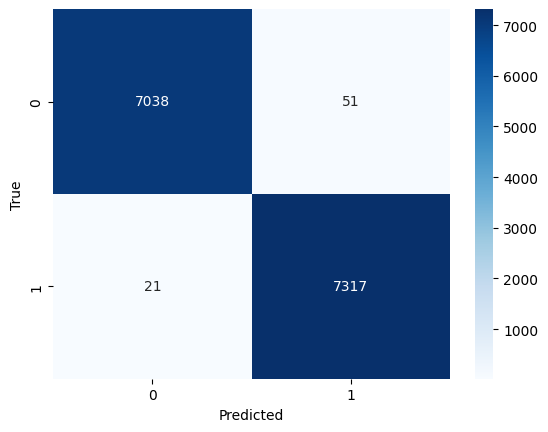

In [5]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the saved model
model_path = "./best_model"
baseline_model = BertForSequenceClassification.from_pretrained(model_path)
baseline_model.to(device)

# Define the compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Define the function to plot the confusion matrix
def plot_confusion_matrix(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Create a Trainer for evaluation
evaluation_args = TrainingArguments(
    output_dir='./results',          
    per_device_eval_batch_size=64,   
    logging_dir='./logs',            
    logging_steps=10,
)

trainer = Trainer(
    model=baseline_model,                         
    args=evaluation_args,                  
    eval_dataset=baseline_test_dataset,
    compute_metrics=compute_metrics
)

# Evaluate the model
baseline_results = trainer.evaluate()
print("Baseline Model Metrics:", baseline_results)

# Predict and plot confusion matrix
predictions = trainer.predict(baseline_test_dataset)
plot_confusion_matrix(predictions)
